In [1]:
import itertools

import pandas as pd
import ipyrad.analysis as ipa
import ipyparallel as ipp
import toyplot
import toyplot.png

In [2]:
%cd /home/a1645424/hpcfs/analysis/shannon/results/population-structure/structure

/scratchdata1/users/a1645424/analysis/shannon/results/population-structure/structure


In [5]:
# Accessory function for dropping samples
def drop_samples(probs: dict, pop_dict: dict) -> dict:
    for k,v in probs.items():
        if k in pop_dict.keys():
            for sample in v:
                if sample in pop_dict[k]:
                    print(f"Dropping: {sample}")
                    pop_dict[k].remove(sample)
    return pop_dict

def drop_pop(drop_list: list, pop_dict: dict) -> dict:
    for p in drop_list:
        if p in pop_dict.keys():
            print(f"Dropping: {p}")
            pop_dict.pop(p)
    return(pop_dict)

In [6]:
spec = "HST"
probs = "dropped-samples.tsv"
ign = f"{spec}-ignore.txt"
data = f"{spec}-stringent.highQ.filtered.LD50k.snps.hdf5"
popmap = f"{spec}-popmap.txt"

In [7]:
# Samples we don't want to include in the analysis
problems = pd.read_csv(
    probs,
    sep = "\t",
    comment="#",
    names = ["sample", "population"]
)
problems = dict(problems.groupby("population")["sample"].apply(list))

with open(ign) as f:
    ignore = f.read().splitlines()

In [8]:
# Burnin/nreps
burnin = 1000000
numreps = 100000

# Population-map file
populations = pd.read_csv(popmap, comment="#", sep=" ", names=["sample", "grouping"])

# Convert to dictionary
imap = dict(populations.groupby("grouping")["sample"].apply(list))
imap = drop_samples(probs=problems, pop_dict=imap)
imap = drop_pop(drop_list=ignore, pop_dict=imap)

# 50% missing data per population group
minmap = {i: 0.5 for i in imap}

Dropping: HST-KLS0360-2562274
Dropping: HST-KLS0634-2892478
Dropping: HST-KLS1679-4013420
Dropping: HST-KLS1677-4013418
Dropping: HST-KLS0660-2892454
Dropping: HST-KLS0886-2892390
Dropping: HST-KLS0941-2892545
Dropping: HST-KLS0897-2892551
Dropping: HST-KLS0896-2892403
Dropping: HST-As012-3991487
Dropping: HST-As010-3991485
Dropping: HST-KLS1204-3593361
Dropping: Gulf_of_Carpentaria
Dropping: Ashmore
Dropping: North_QLD
Dropping: Heywood_Shoal


In [9]:
rerun = ipa.structure(
    data=data,
    name=spec,
    workdir="analysis-structure",
    imap=imap,
    load_only=True,
)

etable = rerun.get_evanno_table( [ 2,3,4,5 ] )
etable

40 previous results loaded for run [HST]


/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1036: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '140.11000000000058' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tab.loc[kpop, "lnPK"] = tab.loc[kpop, "estLnProbMean"] \
/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1040: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '217.69000000000233' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tab.loc[kpop, "lnPPK"] = abs(tab.loc[kpop+1, "lnPK"]
/hpcfs/users/a1645424/micromamba/envs/ipyrad/lib/python3.10/site-packages/ipyrad/analysis/structure.py:1042: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas

,Nreps,lnPK,lnPPK,deltaK,estLnProbMean,estLnProbStdev
2,10,0.00,0.00,0.000,-76111.32,449.868
3,10,140.11,217.69,0.214,-75971.21,1017.600
4,10,357.80,324.71,0.352,-75613.41,921.192
5,10,33.09,0.00,0.000,-75580.32,1089.457


In [10]:
etable.to_csv(f"./{spec}-burnin_{burnin}-numreps-{numreps}-etable.csv")

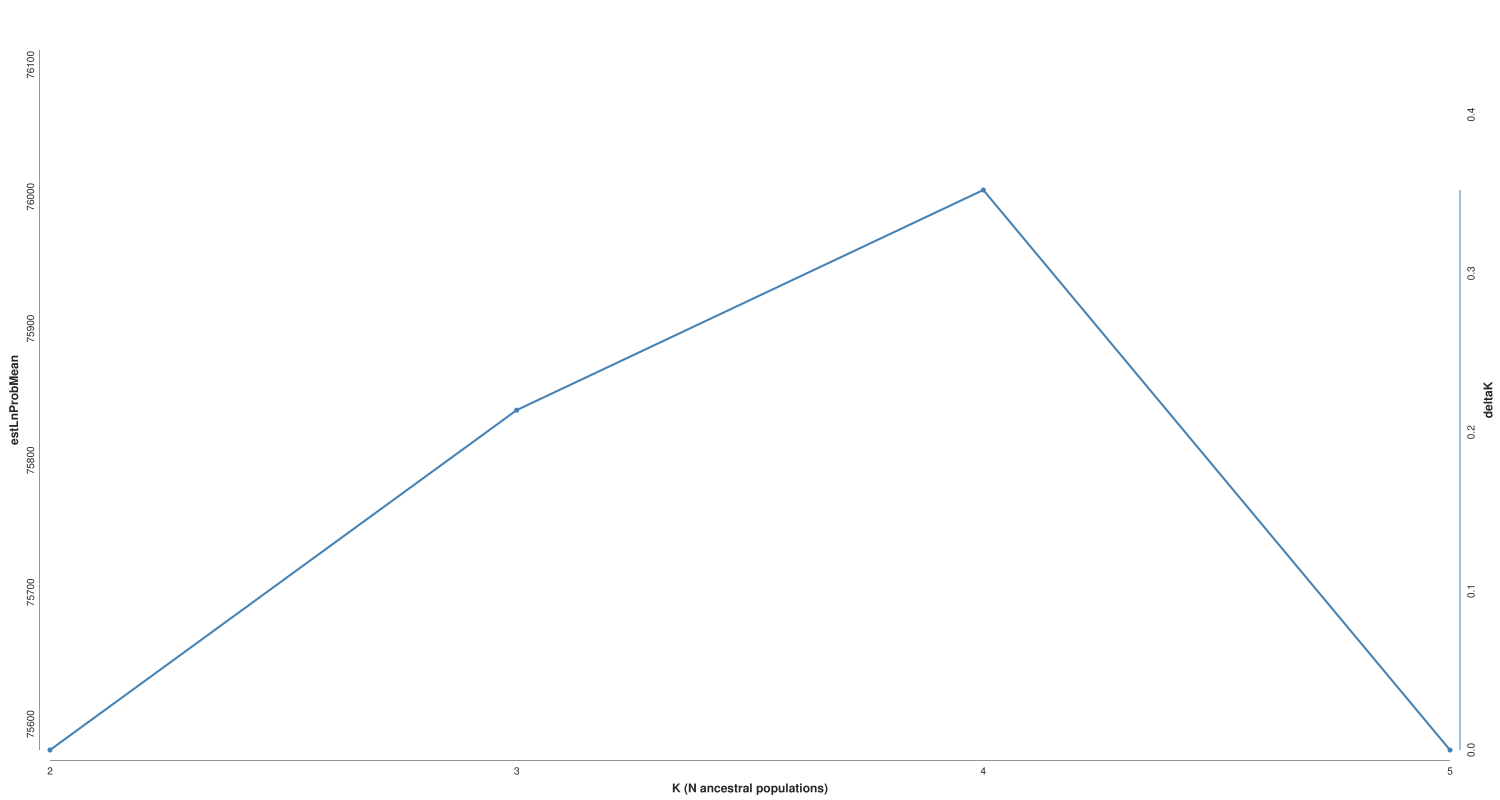

In [11]:
canvas = toyplot.Canvas(width=1500, height=800)
canvas.style.update({"background-color": "white"})

# plot the mean log probability of the models in red
axes = canvas.cartesian(ylabel="estLnProbMean")
axes.plot(etable.estLnProbMean * -1, color="darkred", marker="o")
axes.y.spine.style = {"stroke": "darkred"}

# plot delta K with its own scale bar of left side and in blue
axes = axes.share(
    "x", ylabel="deltaK", ymax=etable.deltaK.max() + etable.deltaK.max() * 0.25
)
axes.plot(etable.deltaK, color="steelblue", marker="o")
axes.y.spine.style = {"stroke": "steelblue"}

# set x labels
axes.x.ticks.locator = toyplot.locator.Explicit(range(len(etable.index)), etable.index)
axes.x.label.text = "K (N ancestral populations)"

# Save figure
# toyplot.png.render(canvas, f"{spec}-deltaK-burnin_{burnin}-numreps_{numreps}.png")
canvas

In [16]:
rerun.clumppparams
rerun.clumppparams.greedy_option = 2

In [12]:
for i in range(2,6):
    table = rerun.get_clumpp_table(i)

    # sort list by columns
    table.sort_values(by=list(range(i)), inplace=True)

    # or, sort by a list of names (here taken from imap)
    onames = list(itertools.chain(*imap.values()))
    table = table.loc[onames]
    table.to_csv(f"{spec}-structure-k{i}-burnin_{burnin}-numreps_{numreps}.plot.csv")

    # build barplot
    canvas = toyplot.Canvas(width=1500, height=800)
    canvas.style.update({"background-color": "white"})
    axes = canvas.cartesian(bounds=("10%", "90%", "10%", "45%"))
    axes.bars(table)

    # add labels to x-axis
    ticklabels = [i for i in table.index.tolist()]
    axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
    axes.x.ticks.labels.angle = -60
    axes.x.ticks.show = True
    axes.x.ticks.labels.offset = 10
    axes.x.ticks.labels.style = {"font-size": "12px"}

    # toyplot.png.render(
    #     canvas, f"{spec}-structure-k{i}-burnin_{burnin}-numreps_{numreps}.png"
    # )

[K2] 10/10 results permuted across replicates (max_var=0).
[K3] 10/10 results permuted across replicates (max_var=0).
[K4] 10/10 results permuted across replicates (max_var=0).
[K5] 10/10 results permuted across replicates (max_var=0).


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1500.0px" height="800.0px" viewBox="0 0 1500.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc787df6679644bdeae73ce1e864be1f5"> HST-KLS1662-4013403 HST-KLS1665-4013406 HST-KLS1666-4013407 HST-KLS1667-4013408 HST-KLS1668-4013409 HST-KLS1669-4013410 HST-KLS1670-4013411 HST-KLS1671-4013412 HST-KLS1673-4013414 HST-KLS1674-4013415 HST-KLS1675-4013416 HST-KLS1676-4013417 HST-KLS1678-4013419 HST-KLS1680-4013421 HST-KLS1681-4013422 HST-KLS1683-4013424 HST-KLS1684-4013425 HST-KLS1685-4013426 HST-KLS1686-4013427 HST-KLS1688-4013428 HST-KLS1689-4013429 HST-KLS1691-4013431 HST-KLS0490-2892498 HST-KLS0527-2892409 HST-KLS0528-2892531 HST-KLS0566-2892525 HST-KLS0573-2892480 HST-KLS0604-2892450 HST-KLS0635-2562180 HST-KLS0636-2562216 HST-KLS0675-2892455 HST-KLS0677-2892491 HST-KLS0678-2892468 HST-KLS0679-2892438 HST-KLS0680-2892474 HST-KLS0681-2892443 HST-KLS0682-2892504 HST-KLS0686-2892505 HST-KLS0687-2892451 HST-KLS1157-3593388 HST-KLS1158-3593383 HST-KLS1159-3593340 HST-KLS1367-3593339 HST-KLS1369-3593347 HST-KLS1370-3593333 HST-KLS1371-3593312 HST-KLS1372-3593318 HST-KLS1380-3593381 HST-KLS1384-3593379 HST-KLS1385-3593310 HST-KLS1412-3593322 HST-KLS1414-3593346 HST-KLS1417-3593370 HST-KLS1418-3593309 HST-KLS1419-3593306 HST-KLS1420-3593353 HST-KLS1422-3593399 HST-KLS1424-3593329 HST-KLS1429-3593311 HST-VU38-2892414 HST-KLS0794-2562199 HST-KLS0795-2892379 HST-KLS0804-2892392 HST-KLS0843-2892452 HST-KLS0847-2892542 HST-KLS0858-2892456 HST-KLS0883-2892509 HST-KLS0923-2892400 HST-KLS0938-2892388 HST-KLS0983-2892406 HST-KLS0986-2892407 HST-KLS1273-2892431 HST-KLS1274-2892410 HST-VU116-2892391 HST-KLS0559-2892377 HST-KLS1173-2892444 HST-KLS1182-2892449 HST-KLS1200-2892434 HST-KLS1206-3593330 HST-KLS1227-2892412 HST-KLS1515-3593385 HST-KLS1517-3593355 HST-KLS1528-3593321 HST-KLS1541-3593313 HST-KLS1544-3593344 HST-KLS1556-3593324 HST-SS170814-01-2562208 HST-SS170820-02-2892469 0.0 0.5 1.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1500.0px" height="800.0px" viewBox="0 0 1500.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tefc890bf87664ed4b24e9ebcdcedafbb"> HST-KLS1662-4013403 HST-KLS1665-4013406 HST-KLS1666-4013407 HST-KLS1667-4013408 HST-KLS1668-4013409 HST-KLS1669-4013410 HST-KLS1670-4013411 HST-KLS1671-4013412 HST-KLS1673-4013414 HST-KLS1674-4013415 HST-KLS1675-4013416 HST-KLS1676-4013417 HST-KLS1678-4013419 HST-KLS1680-4013421 HST-KLS1681-4013422 HST-KLS1683-4013424 HST-KLS1684-4013425 HST-KLS1685-4013426 HST-KLS1686-4013427 HST-KLS1688-4013428 HST-KLS1689-4013429 HST-KLS1691-4013431 HST-KLS0490-2892498 HST-KLS0527-2892409 HST-KLS0528-2892531 HST-KLS0566-2892525 HST-KLS0573-2892480 HST-KLS0604-2892450 HST-KLS0635-2562180 HST-KLS0636-2562216 HST-KLS0675-2892455 HST-KLS0677-2892491 HST-KLS0678-2892468 HST-KLS0679-2892438 HST-KLS0680-2892474 HST-KLS0681-2892443 HST-KLS0682-2892504 HST-KLS0686-2892505 HST-KLS0687-2892451 HST-KLS1157-3593388 HST-KLS1158-3593383 HST-KLS1159-3593340 HST-KLS1367-3593339 HST-KLS1369-3593347 HST-KLS1370-3593333 HST-KLS1371-3593312 HST-KLS1372-3593318 HST-KLS1380-3593381 HST-KLS1384-3593379 HST-KLS1385-3593310 HST-KLS1412-3593322 HST-KLS1414-3593346 HST-KLS1417-3593370 HST-KLS1418-3593309 HST-KLS1419-3593306 HST-KLS1420-3593353 HST-KLS1422-3593399 HST-KLS1424-3593329 HST-KLS1429-3593311 HST-VU38-2892414 HST-KLS0794-2562199 HST-KLS0795-2892379 HST-KLS0804-2892392 HST-KLS0843-2892452 HST-KLS0847-2892542 HST-KLS0858-2892456 HST-KLS0883-2892509 HST-KLS0923-2892400 HST-KLS0938-2892388 HST-KLS0983-2892406 HST-KLS0986-2892407 HST-KLS1273-2892431 HST-KLS1274-2892410 HST-VU116-2892391 HST-KLS0559-2892377 HST-KLS1173-2892444 HST-KLS1182-2892449 HST-KLS1200-2892434 HST-KLS1206-3593330 HST-KLS1227-2892412 HST-KLS1515-3593385 HST-KLS1517-3593355 HST-KLS1528-3593321 HST-KLS1541-3593313 HST-KLS1544-3593344 HST-KLS1556-3593324 HST-SS170814-01-2562208 HST-SS170820-02-2892469 0.0 0.5 1.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1500.0px" height="800.0px" viewBox="0 0 1500.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t46ee7386c9d7413bb01add76d0d4f39c"> HST-KLS1662-4013403 HST-KLS1665-4013406 HST-KLS1666-4013407 HST-KLS1667-4013408 HST-KLS1668-4013409 HST-KLS1669-4013410 HST-KLS1670-4013411 HST-KLS1671-4013412 HST-KLS1673-4013414 HST-KLS1674-4013415 HST-KLS1675-4013416 HST-KLS1676-4013417 HST-KLS1678-4013419 HST-KLS1680-4013421 HST-KLS1681-4013422 HST-KLS1683-4013424 HST-KLS1684-4013425 HST-KLS1685-4013426 HST-KLS1686-4013427 HST-KLS1688-4013428 HST-KLS1689-4013429 HST-KLS1691-4013431 HST-KLS0490-2892498 HST-KLS0527-2892409 HST-KLS0528-2892531 HST-KLS0566-2892525 HST-KLS0573-2892480 HST-KLS0604-2892450 HST-KLS0635-2562180 HST-KLS0636-2562216 HST-KLS0675-2892455 HST-KLS0677-2892491 HST-KLS0678-2892468 HST-KLS0679-2892438 HST-KLS0680-2892474 HST-KLS0681-2892443 HST-KLS0682-2892504 HST-KLS0686-2892505 HST-KLS0687-2892451 HST-KLS1157-3593388 HST-KLS1158-3593383 HST-KLS1159-3593340 HST-KLS1367-3593339 HST-KLS1369-3593347 HST-KLS1370-3593333 HST-KLS1371-3593312 HST-KLS1372-3593318 HST-KLS1380-3593381 HST-KLS1384-3593379 HST-KLS1385-3593310 HST-KLS1412-3593322 HST-KLS1414-3593346 HST-KLS1417-3593370 HST-KLS1418-3593309 HST-KLS1419-3593306 HST-KLS1420-3593353 HST-KLS1422-3593399 HST-KLS1424-3593329 HST-KLS1429-3593311 HST-VU38-2892414 HST-KLS0794-2562199 HST-KLS0795-2892379 HST-KLS0804-2892392 HST-KLS0843-2892452 HST-KLS0847-2892542 HST-KLS0858-2892456 HST-KLS0883-2892509 HST-KLS0923-2892400 HST-KLS0938-2892388 HST-KLS0983-2892406 HST-KLS0986-2892407 HST-KLS1273-2892431 HST-KLS1274-2892410 HST-VU116-2892391 HST-KLS0559-2892377 HST-KLS1173-2892444 HST-KLS1182-2892449 HST-KLS1200-2892434 HST-KLS1206-3593330 HST-KLS1227-2892412 HST-KLS1515-3593385 HST-KLS1517-3593355 HST-KLS1528-3593321 HST-KLS1541-3593313 HST-KLS1544-3593344 HST-KLS1556-3593324 HST-SS170814-01-2562208 HST-SS170820-02-2892469 0.0 0.5 1.0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1500.0px" height="800.0px" viewBox="0 0 1500.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te08906016ba047d9b3d4e342f32db7dc"> HST-KLS1662-4013403 HST-KLS1665-4013406 HST-KLS1666-4013407 HST-KLS1667-4013408 HST-KLS1668-4013409 HST-KLS1669-4013410 HST-KLS1670-4013411 HST-KLS1671-4013412 HST-KLS1673-4013414 HST-KLS1674-4013415 HST-KLS1675-4013416 HST-KLS1676-4013417 HST-KLS1678-4013419 HST-KLS1680-4013421 HST-KLS1681-4013422 HST-KLS1683-4013424 HST-KLS1684-4013425 HST-KLS1685-4013426 HST-KLS1686-4013427 HST-KLS1688-4013428 HST-KLS1689-4013429 HST-KLS1691-4013431 HST-KLS0490-2892498 HST-KLS0527-2892409 HST-KLS0528-2892531 HST-KLS0566-2892525 HST-KLS0573-2892480 HST-KLS0604-2892450 HST-KLS0635-2562180 HST-KLS0636-2562216 HST-KLS0675-2892455 HST-KLS0677-2892491 HST-KLS0678-2892468 HST-KLS0679-2892438 HST-KLS0680-2892474 HST-KLS0681-2892443 HST-KLS0682-2892504 HST-KLS0686-2892505 HST-KLS0687-2892451 HST-KLS1157-3593388 HST-KLS1158-3593383 HST-KLS1159-3593340 HST-KLS1367-3593339 HST-KLS1369-3593347 HST-KLS1370-3593333 HST-KLS1371-3593312 HST-KLS1372-3593318 HST-KLS1380-3593381 HST-KLS1384-3593379 HST-KLS1385-3593310 HST-KLS1412-3593322 HST-KLS1414-3593346 HST-KLS1417-3593370 HST-KLS1418-3593309 HST-KLS1419-3593306 HST-KLS1420-3593353 HST-KLS1422-3593399 HST-KLS1424-3593329 HST-KLS1429-3593311 HST-VU38-2892414 HST-KLS0794-2562199 HST-KLS0795-2892379 HST-KLS0804-2892392 HST-KLS0843-2892452 HST-KLS0847-2892542 HST-KLS0858-2892456 HST-KLS0883-2892509 HST-KLS0923-2892400 HST-KLS0938-2892388 HST-KLS0983-2892406 HST-KLS0986-2892407 HST-KLS1273-2892431 HST-KLS1274-2892410 HST-VU116-2892391 HST-KLS0559-2892377 HST-KLS1173-2892444 HST-KLS1182-2892449 HST-KLS1200-2892434 HST-KLS1206-3593330 HST-KLS1227-2892412 HST-KLS1515-3593385 HST-KLS1517-3593355 HST-KLS1528-3593321 HST-KLS1541-3593313 HST-KLS1544-3593344 HST-KLS1556-3593324 HST-SS170814-01-2562208 HST-SS170820-02-2892469 0.0 0.5 1.0